# Loading MoleculeNet data

This tutorial shows how to load GEOM conformers of [MoleculeNet](https://pubs.rsc.org/en/content/articlehtml/2018/sc/c7sc02664a) species. The approach is the exact same as in `02_loading_rdkit_mols`; however, there are a few folders with results from different levels of theory. This tutorial will explain what those folders are and how to compare their information.

**Note: this tutorial uses MoleculeNet GEOM data, which is not yet publicly available. The data will be uploaded shortly.**

## Different levels of theory
There are four MoleculeNet folders, each with different data computed with different methods. They are:
1. `molecule_net`
    - This is the folder with CREST conformer ensembles computed in **vacuum**. It has data for over 97% of species in ESOL, FreeSolv, Lipophilicity, BACE, BBBP, Tox21, ToxCast, SIDER, and ClinTox.
    - Note that some of the molecules in MoleculeNet are also in GEOM-Drugs. All repeats can be found in either folder.
    

2. `bace_water`
    - This folder has CREST conformer ensembles computed in **water** for the BACE dataset. The solvent was treated with the ALPB model.
    - 1,511 of the 1,513 BACE species are available (99.9%).
    - In addition to the normal CREST/xTB data, each species also has single-point DFT calculations **in water** for most of its CREST conformers.
        - These calculations were performed with the r2scan-3c functional, using the mtzvpp basis, with a PCM description of water
        - The DFT information for each conformer is a value in the conformer dictionary, with the key "r2scan_3c_mtzvpp" (more on that below).
    
    
3. `censo`
    - This folder has CENSO conformer ensembles computed in **water** for the BACE dataset. The solvent was treated with the PCM model; more details of the calculation can be found in the GEOM paper.
    - 1,226 of the 1,513 BACE species are available (81%).
    - The data in each pickle file is organized just like all the others. One thing of note is that each conformer has a value for `confnum` assigned to it. 
        - This is the number of the original CREST conformer that was optimized, and led to the current CENSO conformer. 
        - The numbers are ordered from highest CREST Boltzmann weight to lowest, and start at 1.
        - The original CREST conformer can therefore be found in the `bace_water` folder by matching up its value of `confnum` to that of the CENSO conformer. This can be useful for seeing how much the DFT optimization changed each geometry.
        
   
4. `censo_hess_and_orbs`
    - The final CENSO geometries have Hessians for computing the free energy contribution to the statistical weight. These were computed with the ["single-point Hessian" method](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.0c01306?casa_token=1FkQuhnvzbkAAAAA:FHOXbVkt1ZICCzdgmFbxaK3tbLUNcSUwIj2QXlPVPLivWdxHguUgHdeijb5VYmqg2rLEww1b5U8Mzm0), and so is an *approximation* to the exact r2scan-3c Hessian.
    - Because the Hessians are quite large, we have separated them from the pickle files in `censo` and put them in their own folder, `censo_hess_and_orbs`. We have also put the orbital energies in this folder.
    - Each pickle file is a dictionary, where the keys are conformer IDs and the values are Hessian and orbital information. They can be matched to the `censo` conformers by finding the matching `geom_id` key (more on that below).



## MoleculeNet
Let's start by loading some data from the `molecule_net` folder. As usual we'll start by loading the summary dictionary to figure out what data is available:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

# change to your `molecule_net` path:

molecule_net_path = '/home/saxelrod/rgb_nfs/GEOM/data_after_reviews/molecule_net'
summary_path = os.path.join(molecule_net_path, 'summary.json')

with open(summary_path, 'r') as f:
    summary = json.load(f)

print(len(summary))


8978


Let's see which datasets are available:

In [3]:
datasets = []
for sub_dic in summary.values():
    datasets += sub_dic.get('datasets', [])
datasets = list(set(datasets))
print(datasets)

['bace', 'lipo', 'toxcast', 'bbbp', 'sider', 'pdbbind', 'tox21', 'esol', 'clintox', 'freesolv']


As expected, we see the 9 MoleculeNet datasets mentioned above, plus `pdbbind` (of which there are only a few molecules). Let's find molecules with some `tox21` properties:

3576


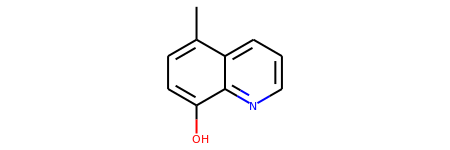

Cc1ccc(O)c2ncccc12


{'pickle_path': 'rd_mols/RPVGLMKJGQMQSN-UHFFFAOYNA-N.pickle',
 'datasets': ['tox21', 'toxcast'],
 'tox21': {'nr-ar': 0.0,
  'nr-ar-lbd': 0.0,
  'nr-ahr': 0.0,
  'nr-aromatase': '',
  'nr-er': '',
  'nr-er-lbd': 0.0,
  'nr-ppar-gamma': '',
  'sr-are': 1.0,
  'sr-atad5': 0.0,
  'sr-hse': 1.0,
  'sr-mmp': 0.0,
  'sr-p53': 1.0},
 'toxcast': {'acea_t47d_80hr_negative': '',
  'acea_t47d_80hr_positive': '',
  'apr_hepg2_cellcyclearrest_24h_dn': '',
  'apr_hepg2_cellcyclearrest_24h_up': '',
  'apr_hepg2_cellcyclearrest_72h_dn': '',
  'apr_hepg2_cellloss_24h_dn': '',
  'apr_hepg2_cellloss_72h_dn': '',
  'apr_hepg2_microtubulecsk_24h_dn': '',
  'apr_hepg2_microtubulecsk_24h_up': '',
  'apr_hepg2_microtubulecsk_72h_dn': '',
  'apr_hepg2_microtubulecsk_72h_up': '',
  'apr_hepg2_mitomass_24h_dn': '',
  'apr_hepg2_mitomass_24h_up': '',
  'apr_hepg2_mitomass_72h_dn': '',
  'apr_hepg2_mitomass_72h_up': '',
  'apr_hepg2_mitomembpot_1h_dn': '',
  'apr_hepg2_mitomembpot_24h_dn': '',
  'apr_hepg2_mitomemb

In [4]:
from rdkit import Chem

sub_dic = {key: val for key, val in summary.items() if 'tox21' in val.get('datasets', [])}
print(len(sub_dic))

# an example species
smiles = list(sub_dic.keys())[0]
mol = Chem.MolFromSmiles(smiles)
display(mol)
print(smiles)
sub_dic[smiles]

We see that this is a rigid molecule (only one unique conformer) with lots of toxicity data:

In [5]:
tox21_dic = sub_dic[smiles]['tox21']
toxcast_dic = sub_dic[smiles]['toxcast']

tox21_avail_keys = [key for key, val in tox21_dic.items()
                   if val != '']
toxcast_avail_keys = [key for key, val in toxcast_dic.items()
                   if val != '']

print(len(tox21_avail_keys))
print(len(toxcast_avail_keys))

9
96


Now let's load all the conformers from species with `esol` properties and see if we can predict any:


In [6]:
import pickle
from tqdm import tqdm

esol_dic = {key: val for key, val in summary.items() if 'esol' in val.get('datasets', [])}
overall_dict = {}

for key in tqdm(esol_dic.keys()):
    val = esol_dic[key]
    pickle_path = os.path.join(molecule_net_path, val['pickle_path'])
    with open(pickle_path, 'rb') as f:
        conf_dic = pickle.load(f)
    overall_dict[key] = conf_dic

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 606/606 [00:33<00:00, 17.91it/s]


Let's see if we can correlate any conformer properties with the experimental water solubility. First we'll get the conformers' WHIM vectors (either of the highest-weight conformer, or statistically averaged):

In [7]:
import numpy as np
from rdkit.Chem.rdMolDescriptors import CalcWHIM


mean_whims = []
highest_prob_whims = []
exp_vals = []

for dic in tqdm(overall_dict.values()):
    
    exp_val = dic['esol']["logsolubility"]
    if exp_val == '':
        continue
    
    confs = dic['conformers']
    valid_idx = [i for i, conf in enumerate(confs) if 
                'boltzmannweight' in conf]
    
    whims = np.array([CalcWHIM(confs[i]['rd_mol']) for i in valid_idx])
    weights = np.array([confs[i]['boltzmannweight'] for i in valid_idx])
    highest_prob_whim = whims[np.argmax(weights)]
    
    # get the thermally averaged WHIM vector
    mean_whim = (weights.reshape(-1, 1) * whims).sum(0)
        
    mean_whims.append(mean_whim)
    highest_prob_whims.append(highest_prob_whim)
    exp_vals.append(exp_val)
    


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 606/606 [00:07<00:00, 77.60it/s]


Now let's do a linear regression:

Highest probability WHIM: R^2 = 0.76


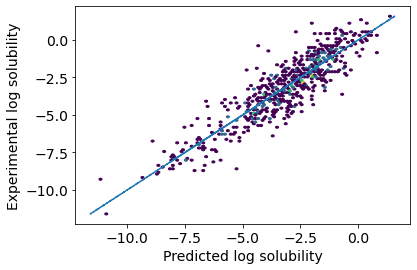

Statistically averaged WHIM: R^2 = 0.77


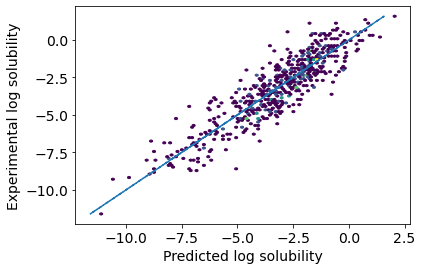

In [8]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.metrics import r2_score
from matplotlib import rcParams

# standardize whim and experimental data, and do a linear regression

exp_vals = np.array(exp_vals).reshape(-1, 1)
mean_whims = np.array(mean_whims)
highest_prob_whims = np.array(highest_prob_whims)

exp_scaler = Scaler().fit(exp_vals)
whim_scaler = Scaler().fit(mean_whims)
highest_whim_scaler = Scaler().fit(highest_prob_whims)


inp_dic = {"Highest probability WHIM": {"whim": highest_prob_whims,
                                        "scaler": highest_whim_scaler},
           "Statistically averaged WHIM": {"whim": mean_whims,
                                           "scaler": whim_scaler}}

for key, sub_dic in inp_dic.items():
        
    whim = sub_dic['whim']
    scaler = sub_dic['scaler']
    
    inp = scaler.transform(whim)
    output = exp_scaler.transform(exp_vals)
    
    reg = LinearRegression().fit(inp, output)        
    
    pred = ((reg.predict(inp)) * exp_scaler.scale_ 
            + exp_scaler.mean_).reshape(-1)
    r2 = r2_score(pred, exp_vals)
    
    print(f"{key}: R^2 = %.2f" % r2)
    
    rcParams.update({"font.size": 14})
    
    plt.hexbin(pred, exp_vals.reshape(-1), mincnt=1)
    plt.xlabel("Predicted log solubility")
    plt.ylabel("Experimental log solubility")
    plt.plot(exp_vals, exp_vals, '--')
    plt.show()

We see that WHIM is actually a very good descriptor for predicting the solubility. We get an $R^2$ value $>0.76$ using only a linear regression! Interestingly, the results are essentially the same whether you average WHIM over all conformers or just use the highest-probability one.


## BACE in water with CREST and CENSO

### Comparing the ensembles

Now let's compare data generated with different levels of theory. In particular we'll look at the BACE dataset, for which we have CREST data in vacuum (from the `molecule_net` folder), CREST data in water (from `bace_water`), and refined DFT ensembles in water (`censo`).

In the `comparing_ensembles` tutorial we'll see how various properties of the ensembles can be compared. For now we'll just load a few examples and compare them qualitatively. Let's start by finding a flexible molecule that inhibits BACE, using `summary.json` as usual:

In [9]:
# change to your `bace_water` path:

bace_water_path = '/home/saxelrod/rgb_nfs/GEOM/data_after_reviews/bace_water'
crest_summary_path = os.path.join(bace_water_path, 'summary.json')

with open(crest_summary_path, 'r') as f:
    crest_summary = json.load(f)

print(f"{len(crest_summary)} molecules in the CREST dataset")

# change to your `censo` path:
bace_censo_path = '/home/saxelrod/rgb_nfs/GEOM/data_after_reviews/censo'
censo_summary_path = os.path.join(bace_censo_path, 'summary.json')

with open(censo_summary_path, 'r') as f:
    censo_summary = json.load(f)

print(f"{len(censo_summary)} molecules in the CENSO dataset")

smiles_in_common = [i for i in censo_summary.keys() if i in 
                   crest_summary]

print(f"{len(smiles_in_common)} molecules in common")


1511 molecules in the CREST dataset
1226 molecules in the CENSO dataset
1226 molecules in common


105
SMILES: CCc1cc(CC2CS(=O)(=O)CC([NH2+]Cc3cccc(C(C)(C)C)c3)C2O)cc(F)c1NC(=O)C[NH+](C)C
{'class': 1.0}
678 CREST conformers


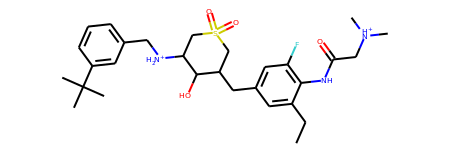

In [10]:
# find an example hit that's flexible

flexible_hits = [smiles for smiles in smiles_in_common if crest_summary[smiles]['uniqueconfs'] > 
                 500 and crest_summary[smiles]['bace']['class'] == 1.0]

print(len(flexible_hits))
smiles = flexible_hits[3]

sub_dic = crest_summary[smiles]
print(f"SMILES: {smiles}")
print(sub_dic['bace'])
print(f"{sub_dic['uniqueconfs']} CREST conformers")
display(Chem.MolFromSmiles(smiles))


Now let's compare the CREST and CENSO ensembles for this molecule. First we'll load the ensembles:

In [11]:
crest_pickle_path = os.path.join(bace_water_path,
                                 crest_summary[smiles]['pickle_path'])

censo_pickle_path = os.path.join(bace_censo_path,
                                 censo_summary[smiles]['pickle_path'])

with open(crest_pickle_path, 'rb') as f:
    crest_dic = pickle.load(f)
    
with open(censo_pickle_path, 'rb') as f:
    censo_dic = pickle.load(f)

RDKit WARNING: [17:38:39] Depickling from a version number (12.1)that is higher than our version (11.0).
[17:38:39] Depickling from a version number (12.1)that is higher than our version (11.0).
This probably won't work.
RDKit WARNING: This probably won't work.
RDKit WARNING: [17:38:39] Depickling from a version number (12.1)that is higher than our version (11.0).
RDKit WARNING: This probably won't work.
RDKit WARNING: [17:38:39] Depickling from a version number (12.1)that is higher than our version (11.0).
RDKit WARNING: This probably won't work.
RDKit WARNING: [17:38:39] Depickling from a version number (12.1)that is higher than our version (11.0).
RDKit WARNING: This probably won't work.
RDKit WARNING: [17:38:39] Depickling from a version number (12.1)that is higher than our version (11.0).
RDKit WARNING: This probably won't work.
RDKit WARNING: [17:38:39] Depickling from a version number (12.1)that is higher than our version (11.0).
RDKit WARNING: This probably won't work.
RDKit WA

And then we'll compare their top 5 highest-probability conformers:

In [12]:
from ase import Atoms
import nglview as nv

num_sample = 5

for name, dic in zip(["Crest", "Censo"], [crest_dic, censo_dic]):
    confs = dic['conformers']
    confs_sample = sorted(confs, key=lambda x: -x.get('boltzmannweight', -1))[:num_sample]
    
    rd_mols = [i['rd_mol'] for i in confs_sample]
    weights = [i['boltzmannweight'] for i in confs_sample]
    
    numbers = np.array([i.GetAtomicNum() for i in rd_mols[0].GetAtoms()])
    # ignore hydrogens
    non_h = numbers != 1
    numbers = numbers[non_h]
    
    ase_atoms = [Atoms(numbers=numbers, 
                       positions=mol.GetConformers()[0].GetPositions()[non_h])
                for mol in rd_mols]
    
    print(name)
    print(f"Boltzmann weights: {weights}")
    display(nv.show_asetraj(ase_atoms))



Crest
Boltzmann weights: [0.49162, 0.05897, 0.04838, 0.04458, 0.03702]


NGLWidget(max_frame=4)

Censo
Boltzmann weights: [0.2152, 0.08779999999999999, 0.08259999999999999, 0.0742, 0.0665]


NGLWidget(max_frame=4)

Interestingly, we see that the highest-probability CENSO geometries tend to be much more spherical than the CREST ones.

We can also see what the CREST geometries look like when we re-rank them by single point DFT energies (i.e., like CENSO but without any further optimization):

In [13]:
from ase import Atoms
import nglview as nv

methods = ['CREST', 'r2scan_3c_mtzvpp']

num_sample = 5

for method in methods:
    
    confs = crest_dic['conformers']
    
    if method == "CREST":
        print("Sorted ")
        confs_sample = sorted(confs, key=lambda x: -x.get('boltzmannweight', -1))[:5]
        weights = [i['boltzmannweight'] for i in confs_sample]
        
    else:
        
        idx = np.array([i for i, conf in enumerate(confs) if method in conf])
        energies = np.array([confs[i][method]['totalenergy'] for i in idx])
        energies -= np.min(energies)
        
        
        # kT at room temp, in atomic units
        kt = 0.000945
        weights = np.exp(-energies / kt)
        weights /= weights.sum()
        
        argsort = np.argsort(-weights)
        confs_sample = [confs[i] for i in argsort[:num_sample]]
        weights = weights[argsort][:num_sample]
        

    rd_mols = [i['rd_mol'] for i in confs_sample]
    
    
    numbers = np.array([i.GetAtomicNum() for i in rd_mols[0].GetAtoms()])
    # ignore hydrogens
    non_h = numbers != 1
    numbers = numbers[non_h]
    
    ase_atoms = [Atoms(numbers=numbers, 
                       positions=mol.GetConformers()[0].GetPositions()[non_h])
                for mol in rd_mols]
    
    print(name)
    print(f"Boltzmann weights: {weights}")
    display(nv.show_asetraj(ase_atoms))



Sorted 
Censo
Boltzmann weights: [0.49162, 0.05897, 0.04838, 0.04458, 0.03702]


NGLWidget(max_frame=4)

Censo
Boltzmann weights: [0.38971355 0.10744149 0.05875959 0.04510098 0.03431822]


NGLWidget(max_frame=4)

The single point re-ranking leads to some more spherical geometries entering the top 5. However, they are not nearly as spherical DFT optimized geometries. This indicates that re-ranking may not be enough to get an accurate ensemble for this molecule.

### Other DFT data

Let's go through some other DFT data that is available in each pickle file. Let's look at the keys in the CENSO dictionary:

In [14]:
conf = censo_dic['conformers'][0]
keys = list(conf.keys())
display(keys)

['rd_mol',
 'geom_id',
 'ExTB',
 'Gtot',
 'homo',
 'lumo',
 'part',
 'Gsolv',
 'GmRRHO',
 'confnum',
 'imgfreq',
 'deltaExTB',
 'deltaGtot',
 'gcpenergy',
 'scfenergy',
 'multipoles',
 'totalenergy',
 'atomiccharges',
 'boltzmannweight',
 'dispersionenergy',
 'electricdipolemomentnorm']

Apart from the normal keys (`rd_mol`, `geom_id`, `totalenergy`, and `boltzmannweight`), we also have some DFT-related keys. Let's go through each of them:

In [15]:
# Units:
# - Energy: 
#       - Default: Hartree (atomic)
#       - HOMO and LUMO: eV
#       - Relative energies (deltaExTB, deltaGtot): kcal/mol
# - Dipole: Debye
        

print("-------------------------")
print("Final energies")
print("-------------------------")
print("Total energy:" , conf["totalenergy"]) # Total energy, including GCP and D3
print('Gtot:', conf['Gtot']) # total r2scan Gibbs free energy, including solvation and modified 
                             # rigid-rotor entropy
g_mrrho = conf['Gtot'] - conf['totalenergy']
print("G_mRRHO:", g_mrrho) # contribution from modified rigid-roto
print("Delta G:", conf['deltaGtot']) # Gibbs free energy relative to the highest-probability geometry,
                                     #  according to DFT
print("Boltzmann weight:", conf['boltzmannweight']) # Boltmzann weight using the free energy
    
print()
print("-------------------------")
print("Energy contributions")
print("-------------------------")
print("GCP energy:", conf["gcpenergy"]) # Geometric counter-poise energy
print("D3 dispersion energy:", conf["dispersionenergy"]) # Disperison D3 energy
print("SCF energy:", conf["scfenergy"]) # SCF energy before GCP and D3 corrections

print()
print("-------------------------")
print("Charge density properties")
print("-------------------------")

dipole = [conf["multipoles"][0][key] for key in ['X', 'Y', 'Z']]
print("Dipole", dipole) # Dipole moment
print("Dipole norm", conf['electricdipolemomentnorm']) # Magnitude of dipole moment
print("Atomic charges", json.dumps(conf['atomiccharges'],
                                  indent=4)) # Partial atomic charges according to different 
                                             # partitioning schemes

print()
print("-------------------------")
print("Comparison to xTB")
print("-------------------------")
print('ExTB:', conf['ExTB']) # xTB energy in solution
print("Delta E xTB:", conf['deltaExTB']) # Energy of this geometry relative to the lowest-energy one, 
                                         # according to xTB
    

print()
print("-------------------------")
print("Other properties")
print("-------------------------")
print('Confnum:', conf['confnum']) # Original ranking of this conformer in the CREST ensemble, before it
                                   # was re-optimized and re-ranked with CENSO r2scan. Starts at 1, not 0.
    
print('Imaginary freqs:', conf['imgfreq']) # Number of imaginary frequencies in the Hessian
print('Gsolv:', conf['Gsolv']) # solvation free energy. Equal to 0 only because solvation is already included in
                               # the DFT calculation, not calculated separately

    
print('HOMO:', conf['homo']) # HOMO
print('LUMO:', conf['lumo']) # LUMO
print('Part:', conf['part']) # What part of the CENSO workflow this geometry came from. 0 = b97 single point
                             # filtering of CREST geoms, 1 = r2scan single point filtering of CREST geoms,
                             # and 2 = r2scan optimization 

-------------------------
Final energies
-------------------------
Total energy: -2094.1252984
Gtot: -2093.5060158
G_mRRHO: 0.6192825999996785
Delta G: 2.11
Boltzmann weight: 0.0060999999999999995

-------------------------
Energy contributions
-------------------------
GCP energy: 0.060382605
D3 dispersion energy: -0.039893591
SCF energy: -2094.1457877

-------------------------
Charge density properties
-------------------------
Dipole [-24.302677820984304, 10.570207541927202, 13.579813000483302]
Dipole norm 29.778528470662756
Atomic charges {
    "mulliken": [
        -0.496888,
        -0.336388,
        0.079383,
        -0.300511,
        0.132513,
        -0.32196,
        0.011829,
        -0.471383,
        0.960281,
        -0.585555,
        -0.587263,
        -0.336583,
        -0.215876,
        -0.273253,
        -0.241314,
        0.058255,
        -0.182767,
        -0.211021,
        -0.142058,
        0.106901,
        0.232506,
        -0.608276,
        -0.525769,
 

Note that DFT properties can also be found for the single-point calculations:

In [16]:
single_point = crest_dic['conformers'][0]['r2scan_3c_mtzvpp']
display(list(single_point.keys()))

['Gtot',
 'GxTB',
 'homo',
 'lumo',
 'part',
 'Gsolv',
 'GmRRHO',
 'confnum',
 'imgfreq',
 'deltaGtot',
 'deltaGxTB',
 'gcpenergy',
 'scfenergy',
 'multipoles',
 'totalenergy',
 'atomiccharges',
 'dispersionenergy',
 'electricdipolemomentnorm',
 'geom_id',
 'smiles']

## Hessian and orbital data
Lastly, we'll look at some extra information about the Hessian of each conformer and its DFT orbitals. This data is stored in a separate file because there's a lot of it.

First we'll load the pickle file:

In [17]:
# change to your path
hess_dir = '/home/saxelrod/rgb_nfs/GEOM/data_after_reviews/censo/hess_and_orbs'

pickle_name = censo_summary[smiles]['pickle_path'].split("/")[-1]
hess_path = os.path.join(hess_dir, pickle_name)

with open(hess_path, 'rb') as f:
    hess_dic = pickle.load(f)


The Hessian / orbital dictionary is organized as `{geom_id: sub_dictionary}` for each conformer, where `geom_id` is the unique ID that labels each conformer in GEOM:

In [18]:
print(hess_dic.keys())

dict_keys([196774480, 196774944, 196775150, 196775265, 196775415, 196775662, 196775807, 196775910, 196776045, 196776140, 196776245, 196776405, 196776480, 196776961, 196777147, 196777252, 196777377, 196777504, 196777689, 196778035, 196778160, 196778323, 196778486, 196778646, 196778766, 196779022, 196779255, 196779529, 196779821, 196779899, 196779953, 196780078])


To get the Hessian information from the conformer we were just looking at, all we need is its `geom_id`:

In [19]:
geom_id = conf['geom_id']
hess_info = hess_dic[geom_id]

Let's look inside this Hessian / orbital dictionary:

In [20]:
display(list(hess_info.keys()))

['geom_id',
 'hessianmatrix',
 'vibdisps',
 'vibfreqs',
 'enthalpy',
 'entropy',
 'freeenergy',
 'imgfreq',
 'ir',
 'zpve',
 'raman',
 'G_rrho',
 'depolar',
 'red_masses',
 'force_const',
 'temperature',
 'G_rrho_no_zpve',
 'dft_orbitals',
 'inp_nxyz',
 'opt_nxyz']

Here's what each key means (we won't print out the values because some are huge). Note that all results were calculated with the "single-point Hessian" method, in which the energy is $E = E_{\mathrm{xTB}} + E_{\mathrm{bias}}$, where $E_{\mathrm{bias}}$ is a biasing energy added to xTB to make up the difference between xTB and DFT. For this reason, the absolute energies are much closer to those of xTB than r2scan. 

- `hessianmatrix`: Hessian matrix in atomic units (Hartree / Bohr)
- `vibdisps`: Eigenvectors of the mass-weighted Hessian, with each component $i$ scaled by the mass $\sqrt{m_i}$ of atom $i$. This is the output given in Orca. To displace atoms along mode $j$, you would move them in the direction `vibdisps[j]`. Note that each vector in `vibdisps` is normalized, but the vectors are not orthogonal to each other, because of the scaling by $\sqrt{m_i}$.
- `vibfreqs`: Vibrational frequencies of the $3N - 6$ normal modes, in units of $cm^{-1}$. 
- `enthalpy`: Enthalpy (including rotation and translation contributions), in Hartree.
- `entropy`: $T \cdot S$, where $T=298.15 \ K$ is the temperature, and $S$ is the odified rigid-rotor entropy. Result is in Hartree.
- `freeenergy`: Gibbs free energy, $G = H - T \cdot S$, in Hartree.
- `imgfreq`: Number of imaginary frequencies in the Hessian
- `ir`: IR intensities
- `zpve`: Zero-point vibrational energy (Hartree).
- `raman`: Raman activities
- `G_rrho`: Modified rigid-rotor contribution to the free energy, in Hartree. Equal to $G - E$. In the CENSO dictionary, the reported free energy $G$ is given by the r2scan energy plus `G_rrho` (check for yourself that that's correct!)
- `depolar`: Depolarizations
- `red_masses`: Reduced masses
- `force_const`: Force constants
- `temperature`: Temperature at which $G$ is calculated, in Kelvin
- `G_rrho_no_zpve`: `G_rrho`, but without the zero-point energy contribution.
- `inp_xyz`: The xyz of the geometry
- `opt_xyz`: The optimized geometry when using the modified energy term $E = E_{\mathrm{xTB}} + E_{\mathrm{bias}}$. Ideally this should be quite close to `inp_xyz`.
- `dft_orbitals`: Orbital energies and occupation numbers computed with DFT. Note that everything else in this dictionary was computed with xTB + biasing potential to approximate DFT, whereas `dft_orbitals` are from a separate calculation, and actually used DFT.

The DFT orbitals are organized as a list of dictionaries, where each dictionary has the occupation of the orbital and its energy:

In [21]:
# first 3 occupied orbitals. Energies are in Hartree

display(hess_info['dft_orbitals'][:3])

# the last 3 unoccupied orbitals

display(hess_info['dft_orbitals'][-3:])

[{'energy': -88.775397, 'number': 1, 'orb_type': 'occ'},
 {'energy': -24.513045, 'number': 2, 'orb_type': 'occ'},
 {'energy': -18.983867, 'number': 3, 'orb_type': 'occ'}]

[{'energy': 43.847085, 'number': 841, 'orb_type': 'unocc'},
 {'energy': 43.903012, 'number': 842, 'orb_type': 'unocc'},
 {'energy': 57.224232, 'number': 843, 'orb_type': 'unocc'}]

We can plot the density of vibrational frequencies:

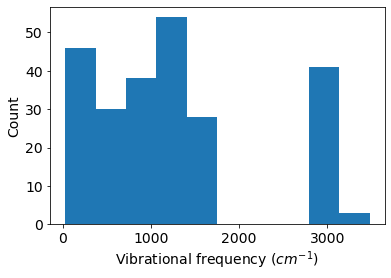

In [22]:
plt.hist(hess_info['vibfreqs'])
plt.xlabel("Vibrational frequency ($cm^{-1}$)")
plt.ylabel("Count")
plt.show()

And lastly, we can see how much the vibrational corrections to the free energy matter:

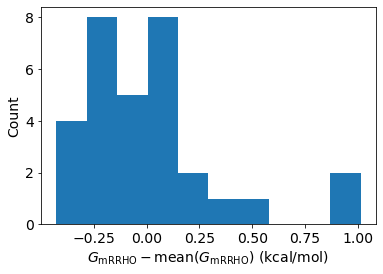

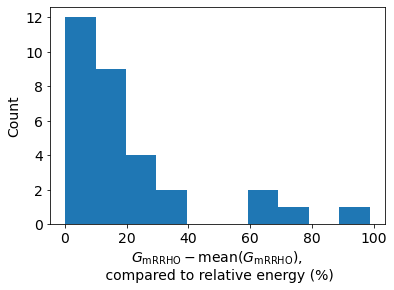

In [23]:
geom_ids = list(hess_dic.keys())
rrho_ens = []
rel_g = []

for geom_id in geom_ids:
    rrho_ens.append(hess_dic[geom_id]['G_rrho'])
    
    conf_dic = [i for i in censo_dic['conformers'] if i['geom_id']
               == geom_id][0]
    rel_g.append(conf_dic['deltaGtot'])
    
rrho_ens = np.array(rrho_ens)
rel_g = np.array(rel_g)
idx = rel_g != 0

# subtract mean, convert to kcal
rrho_ens = (rrho_ens[idx] - np.mean(rrho_ens)) * 627.5
rel_rrho = abs(rrho_ens) / rel_g[idx] * 100

plt.hist(rrho_ens - np.mean(rrho_ens))
plt.ylabel("Count")
plt.xlabel("$G_{\mathrm{mRRHO}} - \mathrm{mean}(G_{\mathrm{mRRHO}} )$ (kcal/mol)")
plt.show()


plt.hist(rel_rrho)
plt.ylabel("Count")
plt.xlabel("$G_{\mathrm{mRRHO}} - \mathrm{mean}(G_{\mathrm{mRRHO}} )$,\n compared to relative energy (%)")
plt.show()


We see that, mostly, the entropic contributions are small ($<20\%$ of the relative energy), but that in some cases they can still be significant.  